## Redshift

In [1]:
import numpy as np
from astropy.io import fits
import glob
import lmfit
import matplotlib.pyplot as plt

In [2]:
balmer = [6564.61, 4862.68, 4341.68]#, 4102.89, 3971.2, 3890.12, 3835.397]

In [3]:
files = glob.glob('../data/*.fits')
filename = files[0]
with fits.open(filename) as f:
    flux = f[1].data['flux']
    lmbd = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

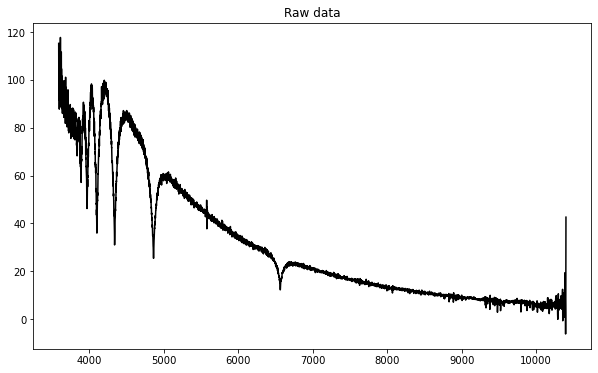

In [4]:
plt.figure(figsize=(10, 6))
plt.title('Raw data')
plt.plot(lmbd, flux, 'k')
plt.show()

To find the total redshift, the following procedure is performed on each of the Balmer series absorption lines:
1. Crop out a window surrounding the absorption line.
2. Ignore the middle half of the window, run a least-squares regression on a linear model across the remaining sections. This gives the expected continuum.  
3. Normalize the cropped window using the continuum.
4. Fit a pseudo-Voigt profile to the dip in the normalized spectrum. Note that here, the profile is subtracted from 1. The centroid of the profile is the empirical wavelength for the Balmer line.
5. Calculate and save the radial velocity needed to produce this redshift.

In [5]:
def lin_res(params, x, data, ivar):
    return (data-lin_model(x, params['m'], params['b']))*np.sqrt(ivar)

def lin_model(x, m, b):
    return m*x + b

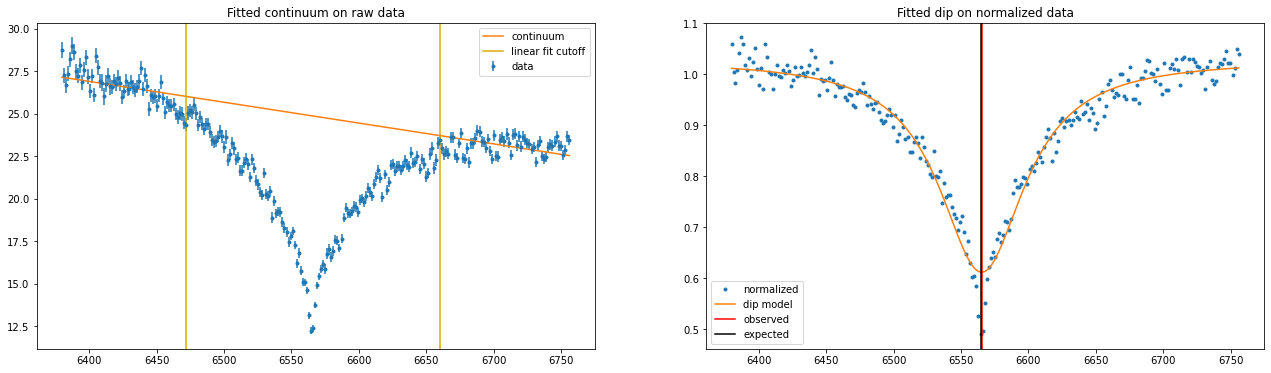

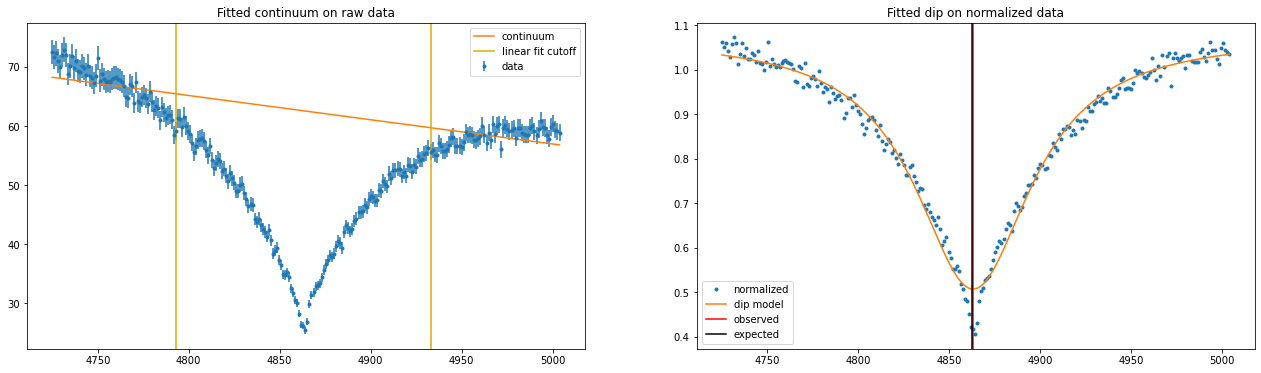

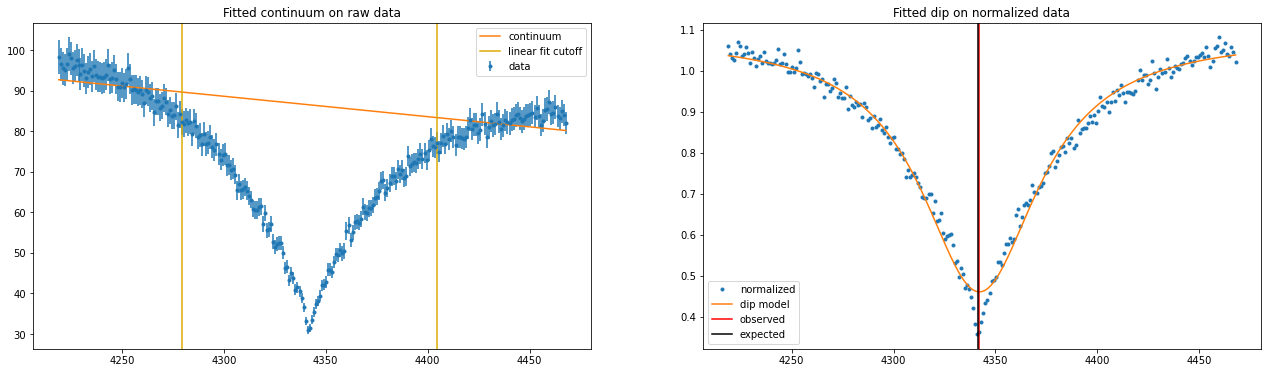

[33.79779806 20.87521252 32.16094599] 	km/s


In [6]:
window_size = 250
c = 3e8
vel = []

for lprp in balmer:
    cdx = np.searchsorted(lmbd, (lprp))
    lmbd_crop = lmbd[cdx-window_size//2:cdx+window_size//2]
    flux_crop = flux[cdx-window_size//2:cdx+window_size//2]
    ivar_crop = ivar[cdx-window_size//2:cdx+window_size//2]
    
    # fit continuum (linear)
    lmbd_corr = np.concatenate((lmbd_crop[:window_size//4], lmbd_crop[3*window_size//4:]))
    flux_corr = np.concatenate((flux_crop[:window_size//4], flux_crop[3*window_size//4:]))
    ivar_corr = np.concatenate((ivar_crop[:window_size//4], ivar_crop[3*window_size//4:]))
    
    lpar = lmfit.Parameters()
    lpar.add('b', value=flux_corr[0], vary=True)
    lpar.add('m', value=0, vary=True)
    lfit = lmfit.minimize(lin_res, lpar, args=(lmbd_corr, flux_corr, ivar_corr))
    m = lfit.params['m'].value
    b = lfit.params['b'].value
    
    flux_cont = lin_model(lmbd_crop, m, b)
    flux_norm = flux_crop/flux_cont
    
    # fit dips (psuedo-voigt)
    cnst = lmfit.models.ConstantModel()
    cnst.set_param_hint('c', value=1, vary=True)
    psvt = lmfit.models.PseudoVoigtModel()
    psvt.set_param_hint('center', value=lprp, vary=True)
    psvt.set_param_hint('amplitude', value=0.5, vary=True)
    psvt.set_param_hint('sigma', value=30, vary=True)
    dpar = psvt.make_params()
    dpar.update(cnst.make_params())
    
    dmodel = cnst-psvt
    dfit = dmodel.fit(flux_norm, dpar, x=lmbd_crop)
    flux_mdip = dmodel.eval(dfit.params, x=lmbd_crop)
    mu = dfit.params['center'].value
    
    # get doppler shift
    lobs = mu
    vel.append(lobs/lprp-1)
    
    # print results
    fig, axes = plt.subplots(1, 2, figsize=(22,6))
    
    axes[0].set_title('Fitted continuum on raw data')
    axes[0].errorbar(lmbd_crop, flux_crop, yerr=1/ivar_crop, fmt='.', label='data')
    axes[0].plot(lmbd_crop, flux_cont, label='continuum')
    axes[0].axvline(x=lmbd_crop[window_size//4], color='#DA0', label='linear fit cutoff')
    axes[0].axvline(x=lmbd_crop[3*window_size//4], color='#DA0')
    axes[0].legend()
    
    axes[1].set_title('Fitted dip on normalized data')
    axes[1].plot(lmbd_crop, flux_norm, '.', label='normalized')
    axes[1].plot(lmbd_crop, flux_mdip, label='dip model')
    axes[1].axvline(x=lobs, color='r', label='observed')
    axes[1].axvline(x=lprp, color='k', label='expected')
    axes[1].legend()
    
    plt.show()

vel = np.array(vel)*c
print(vel/1e3, '\tkm/s')

From the first three Balmer lines, take the mean of the velocities for the total radial velocity of the white dwarf. Note that the relative errors in the fit were incredibly small and using them for a weighted average produced a negligible effect.

Only three Balmer lines were used because the remaining absorption lines overlap one another, making it difficult to find an accurate continuum.

In [7]:
totv = np.mean(vel)
print(totv/1e3, 'km/s')
lmbd_rshf = lmbd / (1 + totv/c)

28.944652193496626 km/s


Below is the corrected spectrum, and a comparison with the raw spectrum.

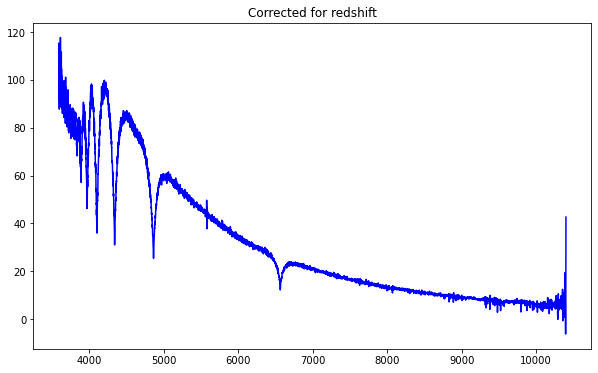

In [8]:
plt.figure(figsize=(10, 6))
plt.title('Corrected for redshift')
plt.plot(lmbd_rshf, flux, 'b')
plt.show()

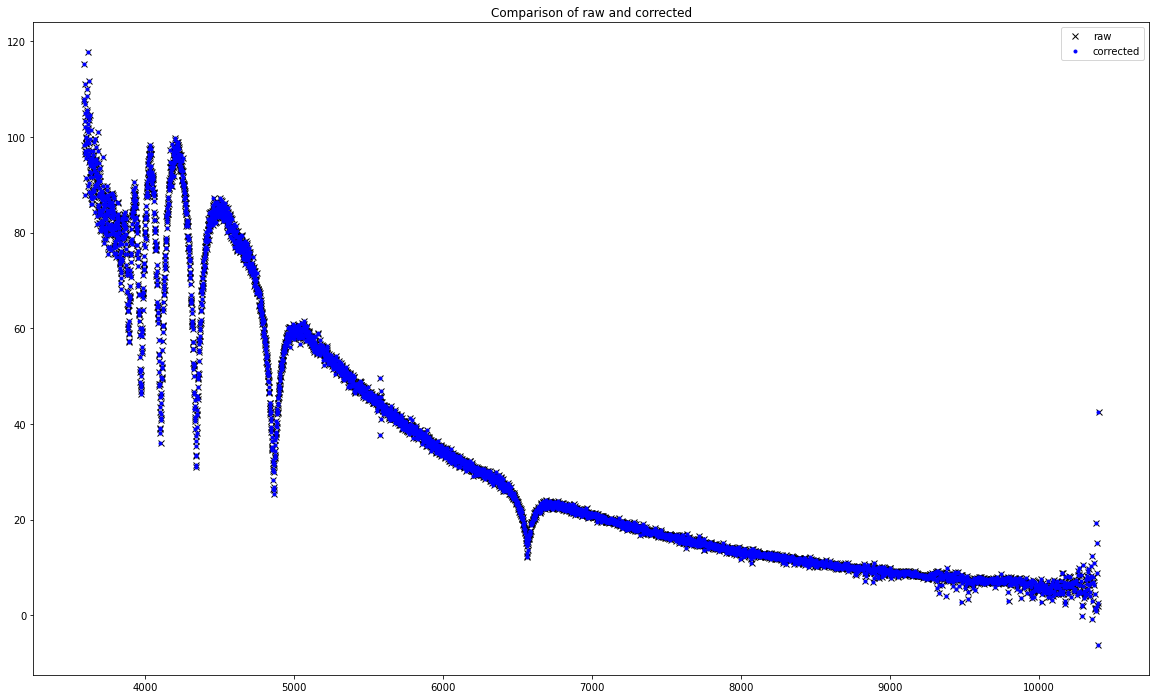

In [9]:
plt.figure(figsize=(20, 12))
plt.title('Comparison of raw and corrected')
plt.plot(lmbd, flux, 'kx', label='raw')
plt.plot(lmbd_rshf, flux, 'b.', label='corrected')
plt.legend()
plt.show()

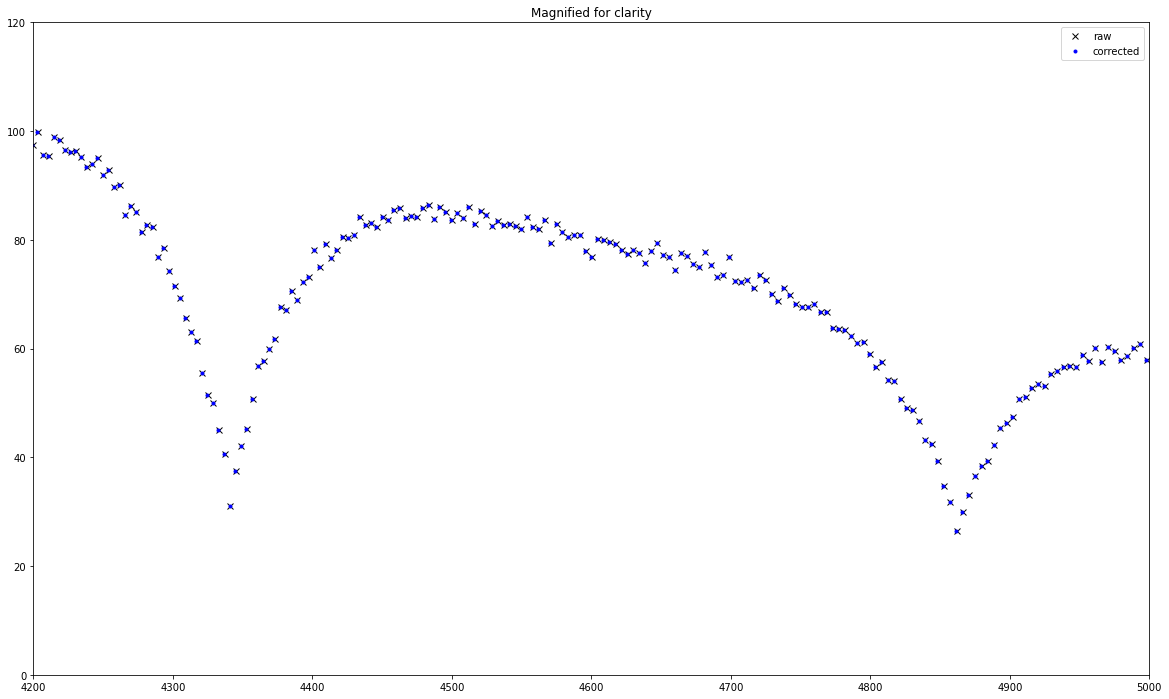

In [10]:
step = 4
lmbd_fltr = lmbd[::step]
lmbd_rshf_fltr = lmbd_rshf[::step]
flux_fltr = flux[::step]

plt.figure(figsize=(20, 12))
plt.title('Magnified for clarity')
plt.plot(lmbd_fltr, flux_fltr, 'kx', label='raw')
plt.plot(lmbd_rshf_fltr, flux_fltr, 'b.', label='corrected')
plt.xlim(4200, 5000)
plt.ylim(0, 120)
plt.legend()
plt.show()